In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.tsa.api as smt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
sns.set(rc={'figure.figsize':(11, 4)})

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

torch.manual_seed(0)

np.random.seed(0)

,Energy_Generated,Efficiency,Energy_Exported,Energy_Used,Peak_Power,Peak_Time,Condition,Min_Temperature,Max_Temperature,Peak_Energy_Import,Off-Peak_Energy_Import,Shoulder_Energy_Import,High-Shoulder_Energy_Import,Insolation
Date,,,,,,,,,,,,,,
2020-02-03,3321,3.075,2910,0,646.0,13:40,Fine,6.0,29.0,NaN,NaN,NaN,NaN,4048
2020-02-04,1611,1.492,1275,0,678.0,14:30,Mostly Cloudy,8.0,16.0,NaN,NaN,NaN,NaN,4084
2020-02-05,4140,3.833,2816,0,737.0,12:40,Fine,0.0,16.0,NaN,NaN,NaN,NaN,4121
2020-02-06,4241,3.927,3585,0,740.0,13:00,Fine,-2.0,20.0,NaN,NaN,NaN,NaN,4157
2020-02-07,2654,2.457,2337,0,740.0,13:00,Fine,0.0,21.0,NaN,NaN,NaN,NaN,4194


2541


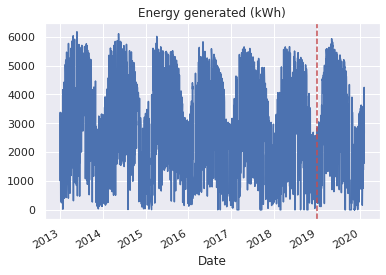

In [2]:
data = pd.read_csv("../DATA_COLLECTOR/AGGREGATION_PRODUCTION/aggreg_PRODUCTION_data.csv")
data.Date = pd.to_datetime(data['Date'],format='%Y%m%d')
data = data.sort_values(by='Date')
data = data[data.Date > '2012-12-31']
data = data.set_index('Date')

display(data.tail())
print(len(data))


data.Energy_Generated = pd.to_numeric(data.Energy_Generated)
data.Energy_Generated.plot(title="Energy generated (kWh)")
thresh_date = '2018-12-31' #'2019-02-07', '2019-08-31'
plt.axvline(x=thresh_date, c='r', linestyle='--')

In [3]:
features = ['Condition','Energy_Generated']
daily_data_with_weather = data[features]
dates = data.index.values

if('Condition' in features):
    conditions = set(daily_data_with_weather['Condition'])

encoder = LabelEncoder()
daily_data_with_weather.Condition = encoder.fit_transform(daily_data_with_weather.Condition)
conditions_labels = set(daily_data_with_weather['Condition'])

le_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(le_name_mapping)

daily_data_with_weather = daily_data_with_weather[daily_data_with_weather.Condition != 3]

train_size = int(len(daily_data_with_weather) * 0.8)
test_size = len(daily_data_with_weather) - train_size
print(train_size,test_size)

# ensure all data is float
daily_data_with_weather = daily_data_with_weather.astype('float32')
daily_data_with_weather = daily_data_with_weather.dropna()
cols = daily_data_with_weather.columns.tolist()


{'Cloudy': 0, 'Fine': 1, 'Mostly Cloudy': 2, 'Not Sure': 3, 'Partly Cloudy': 4, 'Showers': 5}
1976 494


In [4]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length,n_output=1,bias_init_values=[]):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 20 # number of hidden states
        self.n_layers = 1 # number of LSTM layers (stacked)
        self.n_output = n_output

        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)

        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, self.n_output)
    
        if bias_init_values :
            for i in range(self.n_output):
                self.l_linear.bias.data[i] = bias_init_values[i]
               

    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
        self.hidden = (hidden_state, cell_state)


    def forward(self, x):        
        batch_size, seq_len, _ = x.size()

        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        x = lstm_out.contiguous().view(batch_size,-1)
        return self.l_linear(x)

In [5]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [6]:
def run_lstm(train_episodes, batch_size, mv_net, optimizer, trainX, trainY, testX, testY):
    loss_values = []
    val_loss_values = []
    for t in range(train_episodes):
        mv_net.train()
        for b in range(0,len(trainX),batch_size):
            inpt = trainX[b:b+batch_size,:,:]
            target = trainY[b:b+batch_size]    

            x_batch = torch.tensor(inpt,dtype=torch.float32)    
            y_batch = torch.tensor(target,dtype=torch.float32)

            mv_net.init_hidden(x_batch.size(0))
            output = mv_net(x_batch) 
            loss = criterion(output.view(-1), y_batch)  

            loss.backward()
            optimizer.step()        
            optimizer.zero_grad() 
            
        
        loss_values.append(loss)
            
        ##add test
        mv_net.eval()
        mv_net.init_hidden(testX.size(0))
        test_predict = mv_net(testX)
        loss = criterion(test_predict.view(-1), testY)  
        val_loss_values.append(loss)
        if t % 10 == 0:
            print("%d, loss %f val_loss %f" % (t,loss_values[-1],loss)) 

    return loss_values, val_loss_values

In [7]:
def split(data, train_size):
    X, y = split_sequences(data, n_timesteps)

    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:]
    y_test = y[train_size:] 

    trainX = Variable(torch.Tensor(X_train))
    trainY = Variable(torch.Tensor(y_train))

    testX = Variable(torch.Tensor(X_test))
    testY = Variable(torch.Tensor(y_test))

    return trainX, trainY, testX, testY


### Train and test

In [8]:
train_episodes = 200
batch_size = 128
n_features = len(features) # this is number of parallel inputs
n_timesteps = 48 # this is number of timesteps

In [9]:
cv_data = daily_data_with_weather.iloc[:train_size]
cv_dates = dates[:train_size]
print(len(cv_data))

1976



 365 365 730
2014-01-10T00:00:00.000000000 2015-01-16T00:00:00.000000000
0, loss 42.509689 val_loss 22.210695
10, loss 0.152361 val_loss 0.145445
20, loss 0.086244 val_loss 0.076673
30, loss 0.064087 val_loss 0.089239
40, loss 0.055882 val_loss 0.072811
50, loss 0.053543 val_loss 0.069196
60, loss 0.049930 val_loss 0.064425
70, loss 0.045731 val_loss 0.059248
80, loss 0.040915 val_loss 0.053665
90, loss 0.035582 val_loss 0.047694
100, loss 0.030077 val_loss 0.041610
110, loss 0.024904 val_loss 0.035859
120, loss 0.020450 val_loss 0.030836
130, loss 0.016788 val_loss 0.026655
140, loss 0.013788 val_loss 0.023179
150, loss 0.011326 val_loss 0.020215
160, loss 0.009323 val_loss 0.017641
170, loss 0.007717 val_loss 0.015405
180, loss 0.006443 val_loss 0.013487
190, loss 0.005439 val_loss 0.011865
RMSE = 1626


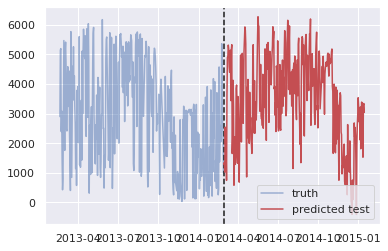


 730 365 1095
2015-01-16T00:00:00.000000000 2016-01-29T00:00:00.000000000
0, loss 52.786774 val_loss 54.927906
10, loss 0.099679 val_loss 0.067937
20, loss 0.064515 val_loss 0.057825
30, loss 0.053618 val_loss 0.051693
40, loss 0.043550 val_loss 0.045688
50, loss 0.035276 val_loss 0.039482
60, loss 0.028174 val_loss 0.032810
70, loss 0.021364 val_loss 0.025782
80, loss 0.015419 val_loss 0.019195
90, loss 0.010842 val_loss 0.013861
100, loss 0.007632 val_loss 0.010046
110, loss 0.005511 val_loss 0.007464
120, loss 0.004136 val_loss 0.005722
130, loss 0.003231 val_loss 0.004542
140, loss 0.002615 val_loss 0.003742
150, loss 0.002180 val_loss 0.003194
160, loss 0.001864 val_loss 0.002812
170, loss 0.001629 val_loss 0.002542
180, loss 0.001452 val_loss 0.002348
190, loss 0.001317 val_loss 0.002211
RMSE = 1698


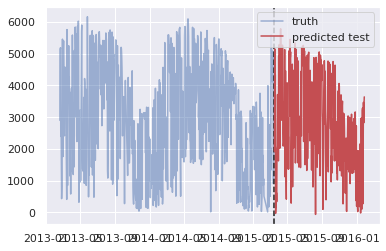


 1095 365 1460
2016-01-29T00:00:00.000000000 2017-02-16T00:00:00.000000000
0, loss 13.612206 val_loss 16.006647
10, loss 0.066312 val_loss 0.088748
20, loss 0.053440 val_loss 0.061905
30, loss 0.049347 val_loss 0.056872
40, loss 0.048432 val_loss 0.057379
50, loss 0.047138 val_loss 0.055112
60, loss 0.044285 val_loss 0.050470
70, loss 0.038417 val_loss 0.042721
80, loss 0.027730 val_loss 0.030571
90, loss 0.014202 val_loss 0.016332
100, loss 0.005356 val_loss 0.006967
110, loss 0.002671 val_loss 0.004186
120, loss 0.002166 val_loss 0.003621
130, loss 0.001992 val_loss 0.003069
140, loss 0.001959 val_loss 0.002802
150, loss 0.002115 val_loss 0.002715
160, loss 0.002304 val_loss 0.002677
170, loss 0.002549 val_loss 0.002663
180, loss 0.002849 val_loss 0.002583
190, loss 0.003322 val_loss 0.002411
RMSE = 1721


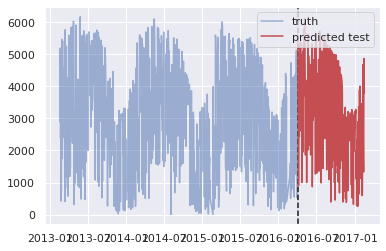


 1460 365 1825
2017-02-16T00:00:00.000000000 2018-02-18T00:00:00.000000000
0, loss 3.271573 val_loss 0.707061
10, loss 0.076161 val_loss 0.055400
20, loss 0.032927 val_loss 0.035553
30, loss 0.009620 val_loss 0.012398
40, loss 0.001763 val_loss 0.004055
50, loss 0.000435 val_loss 0.007426
60, loss 0.000430 val_loss 0.008421
70, loss 0.000813 val_loss 0.009219
80, loss 0.001490 val_loss 0.010357
90, loss 0.002066 val_loss 0.009470
100, loss 0.002495 val_loss 0.010166
110, loss 0.002569 val_loss 0.007268
120, loss 0.005696 val_loss 0.012431
130, loss 0.000585 val_loss 0.002930
140, loss 0.000189 val_loss 0.000222
150, loss 0.000178 val_loss 0.000189
160, loss 0.001605 val_loss 0.000276
170, loss 0.000249 val_loss 0.000175
180, loss 0.030687 val_loss 0.021390
190, loss 0.000103 val_loss 0.000211
RMSE = 1755


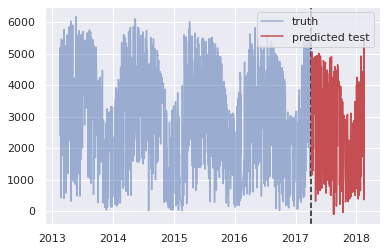

In [10]:
rmse_list = []
cv_test_size = 365
resid_list = []

for cv_train_size in range(cv_test_size,train_size,cv_test_size):
    print("\n", cv_train_size, cv_test_size, cv_train_size+cv_test_size)
    print(dates[cv_train_size], dates[cv_train_size+cv_test_size])

    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(cv_data.iloc[:cv_train_size])
    scaled = scaler.transform(cv_data.iloc[:cv_train_size+cv_test_size])
    target_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler.fit(cv_data.iloc[:cv_train_size].Energy_Generated.values.reshape(-1,1))

    # select data
    trainX, trainY, testX, testY = split(scaled, cv_train_size)

    # create NN
    mv_net = MV_LSTM(n_features,n_timesteps)
    criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
    optimizer = torch.optim.Adam(mv_net.parameters(), lr=1e-1,weight_decay=0.001)

    # train
    loss_values, val_loss_values = run_lstm(train_episodes, batch_size, mv_net, optimizer, trainX, trainY, testX, testY)

    # eval
    mv_net.eval()
    mv_net.init_hidden(testX.size(0))
    test_predict = mv_net(testX).detach().numpy()
    test_predict = target_scaler.inverse_transform(test_predict.reshape(-1, 1))

    lstm_rmse = mean_squared_error(test_predict[:,0],cv_data['Energy_Generated'].iloc[cv_train_size + n_timesteps:cv_train_size + cv_test_size:1] ,squared=False)
    print("RMSE = %d" % lstm_rmse) 

    rmse_list.append(lstm_rmse)

    # Get resid of training
    mv_net.init_hidden(trainX.size(0))
    train_predict = mv_net(trainX)
    train_predict = train_predict.data.numpy()
    train_predict = target_scaler.inverse_transform(train_predict.reshape(-1, 1))
    train_truth = cv_data['Energy_Generated'].iloc[n_timesteps:cv_train_size + n_timesteps:1]
    resid_list.append(train_predict[:,0] - train_truth.values)

    # plot graph of predictions
    x_train = cv_dates[n_timesteps:cv_train_size + n_timesteps:1]
    plt.plot(x_train, train_truth.values, alpha=0.5, label="truth", c='b')
    #plt.plot(x_train, train_predict[:,0], label="predicted", c='r', alpha=0.5)

    plt.axvline(x=cv_dates[cv_train_size+n_timesteps], c='k', linestyle='--')
    
    test_truth = cv_data['Energy_Generated'].iloc[cv_train_size + n_timesteps:cv_train_size + cv_test_size:1]
    x_test = cv_dates[cv_train_size + n_timesteps:cv_train_size + cv_test_size:1]
    #plt.plot(x_test, test_truth.values[:], c='b')
    plt.plot(x_test, test_predict[:,0], label="predicted test", c='r')
    

    plt.legend()
    plt.show()

In [11]:
def show_resid(resid, i):
    sns.kdeplot(resid, label="{} years of training".format(i+1))
    k2, p  = stats.normaltest(resid)
    print("mean =", np.mean(resid), "/ std  =", np.std(resid), "/ p =",  p)

mean = -34.94813 / std  = 1692.0981 / p = 0.7388444604273576
mean = -282.69626 / std  = 1676.4796 / p = 0.21479261270247754
mean = 274.44156 / std  = 1693.4677 / p = 0.8979484382723413
mean = -180.70222 / std  = 1713.31 / p = 0.669759733068074


<function matplotlib.pyplot.show(*args, **kw)>

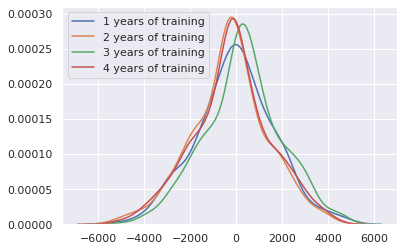

In [12]:
sns.set(rc={'figure.figsize':(8, 3)})

for i, resid in enumerate(resid_list):
    show_resid(resid, i)
plt.legend()
plt.show

1700.5216 47.518665


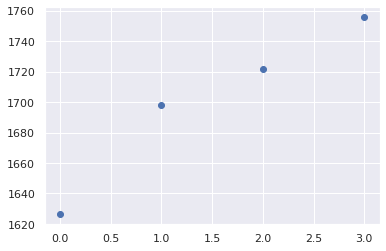

In [13]:
print(np.mean(rmse_list), np.std(rmse_list))
plt.scatter(np.arange(len(rmse_list)), rmse_list)